In [11]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

from sklearn.pipeline import Pipeline
plt.style.use(['dark_background'])


### Gradient boost guided example

Now that you've walked through gradient boost by hand, try it with scikit-learn. You'll still use the *European Social Survey* data, but now with a categorical outcome: whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
# Set the outcomes to `0` and `1`.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable `country` into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

Because you're now working with a binary outcome, you've switched to a classifier. Now your loss function can't be the residuals. Your options are `deviance` and `exponential`. The `deviance` loss function is used for logistic regression, and you'll try that here.

In [32]:
# You'll make 500 iterations, use 2-deep trees, and set your loss function.

# It's best to update this table for the drill 
# at the end of the checkpoint.

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [15]:
pipeline = Pipeline(
    [
        ("model", ensemble.GradientBoostingClassifier(random_state=28))
    ]
)

In [27]:
grid = {
    "model__learning_rate": 
    [
#         0.025,
#         0.04,
        0.05,
#         0.06,
#         0.075
#         0.1, 
#         0.15, 
#         0.2, 
#         0.25
    ],
    "model__max_depth": 
    [
        2,
#         3,
#         4,
#         5
    ],
    "model__n_estimators": 
    [
#         50,
#         100,
#         125,
        150,
#         175,
#         200,
#         300,
#         400,
#         500
    ],
    "model__loss": [
        "deviance", 
#         'eponential'
    ],
    "model__subsample": 
    [
#         0.5,
#         0.6,
        0.65,
#         0.7,
#         0.75,
#         0.85,
#         1.0
    ],
    "model__min_samples_split": 
    [
        2,
#         3,
#         5
    ],
}

In [19]:
from sklearn.model_selection import GridSearchCV

In [28]:
pipeline_cv = GridSearchCV(pipeline, grid, cv=2, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

print("Best hyperparameters:")
pipeline_cv.best_params_

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.7s finished


Best hyperparameters:


{'model__learning_rate': 0.05,
 'model__loss': 'deviance',
 'model__max_depth': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 150,
 'model__subsample': 0.65}

In [33]:
pcv_predict_train = pipeline_cv.predict(X_train)
pcv_predict_test = pipeline_cv.predict(X_test)

### Evaluation of model: Confusion matrix plot

This plot is based on an example from [scikit-learn's documentation](https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html).

In [4]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


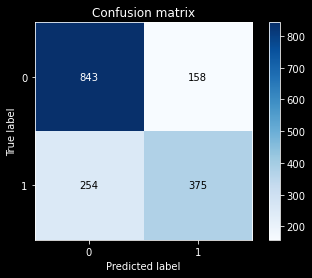

In [34]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Confusion matrix, without normalization


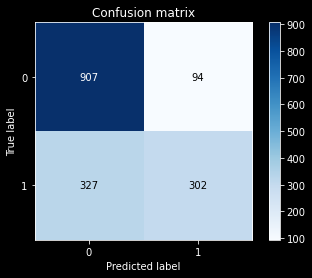

In [35]:
cm = confusion_matrix(y_test, pcv_predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


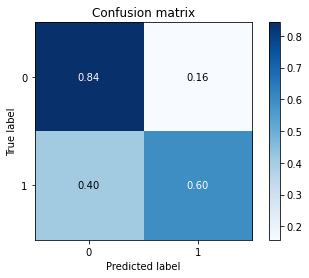

In [6]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

Normalized confusion matrix


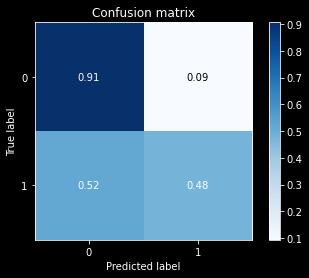

In [36]:
cm = confusion_matrix(y_test, pcv_predict_test)
plot_confusion_matrix(cm,[0,1],True)

#### Accuracy

In [45]:
clf.score(X_test, y_test)

0.747239263803681

In [46]:
pipeline_cv.score(X_test, y_test)

0.741717791411043

#### Precision

In [42]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred)

0.7035647279549718

In [41]:
pcv_y_pred = pipeline_cv.predict(X_test)
precision_score(y_test,pcv_y_pred)

0.7626262626262627

#### Recall

In [43]:
recall_score(y_test,y_pred)

0.5961844197138315

In [44]:
recall_score(y_test,pcv_y_pred)

0.48012718600953896

Unlike decision trees, gradient boost solutions aren't terribly easy to interpret on the surface. But they aren't quite black boxes either. You can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

In [49]:
params = {
    'n_estimators': 150,
    'max_depth': 2,
    'loss': 'deviance',
    'subsample': 0.65,
    'learning_rate': 0.05,
         }

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(X_train, y_train)

predict_train = clf2.predict(X_train)
predict_test = clf2.predict(X_test)

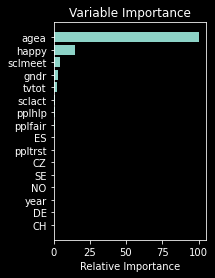

In [52]:
# feature_importance = clf.feature_importances_
feature_importance = clf2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### Drill: Improve this gradient boost model

This model is already doing all right, but there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Here are some strategies that you might use:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* Making more iterations
* Trying a different loss function
* Changing the structure of the weak learner by allowing more leaves in the tree or using other modifications

You can learn more about the parameters for the gradient boost model [in scikit-learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). You can update the *params* table featured earlier, before you initialized and fit the model.

Here are a few of the parameters that you could tune:
 - `learning_rate`
 - `max_depth`
 - `n_estimators`
 - `loss`
 - `subsample`
 - `min_samples_split`
 
You can then use the same metrics to evaluate your results.
          
Have fun!